In [1]:
#ds=xr.Dataset({'zKa':(['time','height'],np.array(zKaL)),'zKu':(['time','height'],np.array(zKuL)),'zW':(['time','height'],np.array(zWL)),'h':(['time','height'],np.array(hL)),'lon':(['time'],np.array(lonL)),'lat':(['time'],np.array(latL)),},coords={'time':t_corr[n1:n2],'height':h01[ah],'vDopKu':(['time','height'],np.array(vdopKuL)),'timeL':(['time'],np.array(timeSubL))})
#!ls IMPACTS
#'IMPACTS2022_20220203_%i_%i.nc'%(n1,n2)
import glob
fs=sorted(glob.glob("Subsets/IMPACTS*.nc"))
print(fs)

['Subsets/IMPACTS2022_20220203_1000_4000.nc', 'Subsets/IMPACTS2022_20220208_14200_17000.nc', 'Subsets/IMPACTS2022_20220208_9200_10800.nc', 'Subsets/IMPACTS2022_20230217_1000_4000.nc', 'Subsets/IMPACTS2022_20230217_13900_16600.nc', 'Subsets/IMPACTS2022_20230217_17750_19300.nc', 'Subsets/IMPACTS2022_20230217_5300_12700.nc']


In [2]:
import netCDF4 as nc 
import numpy as np
fname=fs[0]
with nc.Dataset(fname) as f:
    print(f.variables.keys())
    zKa=f.variables['zKa'][:]
    zKu=f.variables['zKu'][:]
    zW=f.variables['zW'][:]
    h=f.variables['h'][:]
    lon=f.variables['lon'][:]
    lat=f.variables['lat'][:]
    time=f.variables['time'][:]
    vdopKu=f.variables['vDopKu'][:]
    timeL=f.variables['timeL'][:]

dict_keys(['zKa', 'zKu', 'zW', 'h', 'lon', 'lat', 'time', 'height', 'vDopKu', 'timeL'])


(3000,) (3000,) (3000, 421)


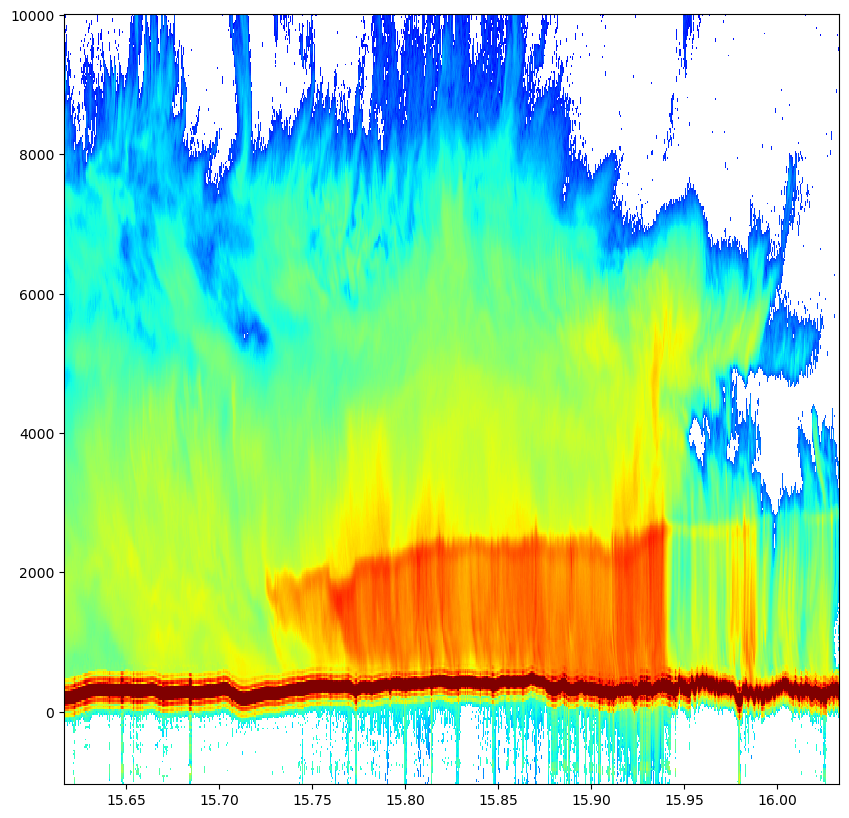

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
print(timeL.shape,h[:,0].shape,zKa.shape)
plt.pcolormesh(timeL,h[0,:],zKa.T,cmap='jet',vmin=-20,vmax=40)

[0.10556368 0.21371882 0.31942945 0.42741241 0.53276606 0.64110223
 0.74679561 0.85487127 0.96083759 1.06866812 1.17440883 1.28249807
 1.38848153 1.49632493 1.60236276 1.70968376 1.81568615 1.92363174
 2.02935779 2.13759232 2.24351004 2.351619   2.45772918 2.56574729
 2.67192128 2.77998285 2.88586926 2.99427533 3.10049372 3.20863625
 3.31492517 3.42249943 3.52882276 3.63696612 3.7433346  3.85160493
 3.95788695 4.06610385 4.17263252 4.28108305 4.38695627 4.49594579
 4.60245207 4.71096615 4.81745181]


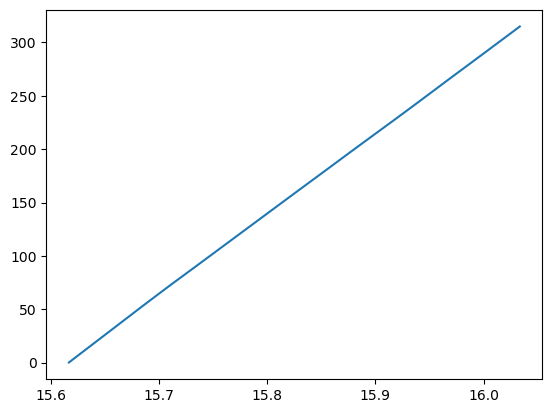

In [4]:
# calculate the distance between two points on the earth's surface

def distance(lat1, lon1, lat2, lon2):
    #print(lat1,lon1,lat2,lon2)
    # use harvesine formula
    r = 6371 # radius of earth in km
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return r * c
distL=[]

for i in range(1,len(lon)):
    distL.append(distance(lat[i-1],lon[i-1],lat[i],lon[i]))
plt.plot(timeL[1:],np.cumsum(distL))
dist_cum=np.cumsum(distL)
print(dist_cum[:45])

In [48]:
fov_dt_microw=4.5

distL=np.array(distL)
ndpr=distL.shape[0]//51
zKa_dprL=[]
zKu_dprL=[]
vDop_dprL=[]
hLT=[]
for i in range(ndpr):
    FWHMx=fov_dt_microw
    d1=distL[i*51:(i+1)*51].cumsum()
    ddx=d1-d1[25]
    #print(ddx)
    y2=((ddx/FWHMx)**2*np.log(2.))
    beam_w=np.exp(-y2)
    beam_w=beam_w/beam_w.sum()
    gain=beam_w**2
    gain=gain/gain.sum()
    zKu_avg=np.zeros((zKu.shape[1]),float)
    zKa_avg=np.zeros((zKa.shape[1]),float)
    vDop_avg=np.zeros((vdopKu.shape[1]),float)  

    for j in range(51):
        a=np.nonzero(zKu[i*51+j,:].data!=zKu[i*51+j,:].data)
        zKu[i*51+j,a]=-99.9
        a=np.nonzero(zKa[i*51+j,:].data!=zKa[i*51+j,:].data)
        zKa[i*51+j,a]=-99.9
        #print(zKu[i*51+j,:])
        zKu_avg+=10**(0.1*zKu[i*51+j,:])*gain[j]
        zKa_avg+=10**(0.1*zKa[i*51+j,:])*gain[j]
        vDop_avg+=vdopKu[i*51+j,:]*gain[j]
    hLT.append(h[i*51+25,:])
    zKu_dprL.append(10*np.log10(zKu_avg))
    zKa_dprL.append(10*np.log10(zKa_avg))
    vDop_dprL.append(vDop_avg)
    #break

(58, 421)
(58, 421)
zku (58, 421)
hlt (58, 421)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_24716/1552459101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKu_dpr_m[:,::-1][:,::5],cmap='jet',vmin=10,vmax=40)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_24716/1552459101.py:43: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKa_dpr_m[:,:][:,::5],cmap='jet',vmin=10,vmax=40)
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_24716/1552459101.py:50: UserWarning: The input coordinates to pcolormesh are i

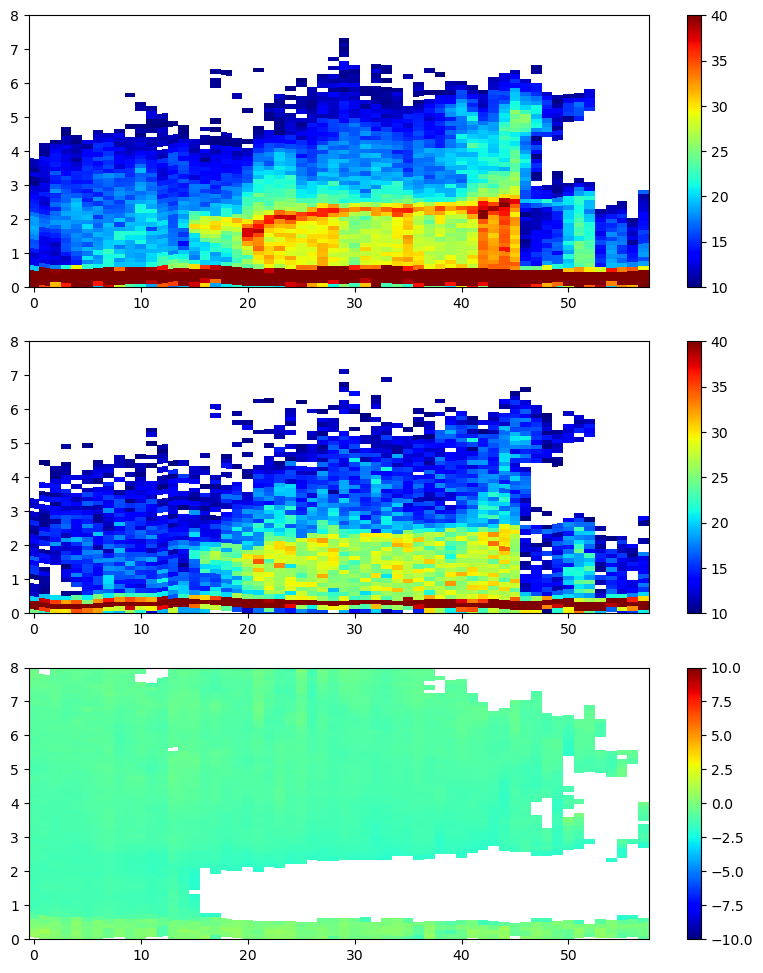

In [51]:
#plt.plot(gain)
fig=plt.figure(figsize=(10,12))
hLT=np.array(hLT)
zKu_dpr=np.array(zKu_dprL)
zKa_dpr=np.array(zKa_dprL)
n1=np.random.randn(zKu_dpr.shape[0],zKu_dpr.shape[1])
n2=np.random.randn(zKa_dpr.shape[0],zKa_dpr.shape[1])*2
zKu_dpr_m=np.ma.masked_where(zKu_dpr+n1<10,zKu_dpr+n1)
zKa_dpr_m=np.ma.masked_where(zKa_dpr+n2<10,zKa_dpr+n2)

print(hLT.shape)
x=range(zKu_dpr_m.shape[0])
x2D=np.array([x for k in range(zKu_dpr_m.shape[1])])
print(x2D.T.shape)
print('zku',zKu_dpr_m.shape)
print('hlt',hLT.shape)
from mpldatacursor import datacursor
coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print (f'x = {ix}, y = {iy}')

    global coords
    coords.append((ix, iy))
    
    if len(coords) == 10:
        fig.canvas.mpl_disconnect(cid)

    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.subplot(3,1,1)
plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKu_dpr_m[:,::-1][:,::5],cmap='jet',vmin=10,vmax=40)
plt.ylim(0,8)


#datacursor()
#get coordinates from the plot using the cursor

plt.colorbar()
plt.subplot(3,1,2)
plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],zKa_dpr_m[:,:][:,::5],cmap='jet',vmin=10,vmax=40)
plt.ylim(0,8)
plt.colorbar()

plt.subplot(3,1,3)
vDop_dprL=np.array(vDop_dprL)
vDop_dpr_m=np.ma.masked_where(vDop_dprL<-2,vDop_dprL)
plt.pcolormesh(x2D.T[:,::5],(hLT/1e3)[:,::5],vDop_dpr_m[:,::-1][:,::5],cmap='jet',vmin=-10,vmax=10)
plt.ylim(0,8)
plt.colorbar()


26.25
[]


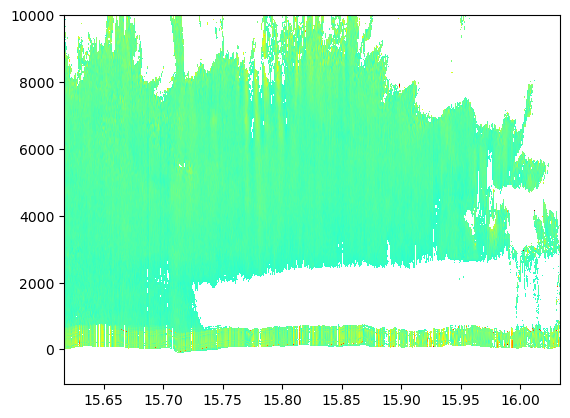

In [53]:
print(hLT[0,0]-hLT[0,1])
print(coords)
vdopKu_m=np.ma.masked_where(vdopKu<-2,vdopKu)
plt.pcolormesh(timeL,h[0,:],vdopKu_m[:,::-1].T,cmap='jet',vmin=-10,vmax=10)